In [2]:
%pip install geopandas

  Using cached geopandas-0.12.2-py3-none-any.whl (1.1 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 6.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 10.4 MB/s eta 0:00:0000:0100:01
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)
  Using cached click-8.1.3-py3-none-any.whl (96 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
%pip install pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 6.8 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=b6a4ac140fca4bcc4206069614c74ae32562b2a9d75825792b490f16d876c93d
  Stored in directory: /Users/albertcortbanke/Library/Caches/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built pycountry
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
import pycountry
from shapely import wkt
import fiona

# Visualization 
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

1. Read in the HFI data

In [3]:
df_2022 = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/hfi/hfi_cc_2022.csv')

2. Read in the GeoJSON data

In [4]:
countries_gpd = gpd.read_file('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/country_geometry_json/world-administrative-boundaries.shp')

What can the Human Freedom Score measure, and more importantly, what is it unable to measure?
What attributes are the most important to explore missingness within? (I.e what attributes correlate highly, and would be pointless to measure within)

Spatial, and temporal missingness. How do we address this with spatial models and temporal accountance?


## Merging of geometries and HFI data frame

3. Create a mapping function to convert country names to their corresponding ISO 3166-1 alpha-3 country codes:

In [5]:
def get_country_code(country_name):
    # Handle exceptions directly
    exception_mapping = {
        'Democratic Republic of the Congo': 'COD',
        'The Bahamas': 'BHS',
        'Ivory Coast': 'CIV',
        'Iran': 'IRN',
        'Laos': 'LAO',
        'Russia': 'RUS'
    }
    
    if country_name in exception_mapping:
        return exception_mapping[country_name]
    
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None


In [6]:
country_name_mapping = {
    'Bahamas, The': 'The Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'South Korea',
    'Lao PDR': 'Laos',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen'
}

In [7]:
df_2022['countries'] = df_2022['countries'].replace(country_name_mapping)

df_2022['country_code'] = df_2022['countries'].apply(get_country_code)

In [8]:
countries_gpd = countries_gpd.rename(columns={"iso3": "country_code"})

In [9]:
# Select only the 'country_code' and 'geometry' columns from the GeoPandas DataFrame
countries_gpd_filtered = countries_gpd[['country_code', 'geometry']]

# Merge the DataFrames on the 'country_code' column
merged_gdf = df_2022.merge(countries_gpd_filtered, on='country_code', how='left')

# Convert the merged DataFrame to a GeoDataFrame, using the 'geometry' column as the geometry
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')


In [10]:
merged_gdf.geometry.isnull().value_counts()

False    3486
Name: geometry, dtype: int64

## Feature selection (mulitcollinarity & VIF)

<AxesSubplot:>

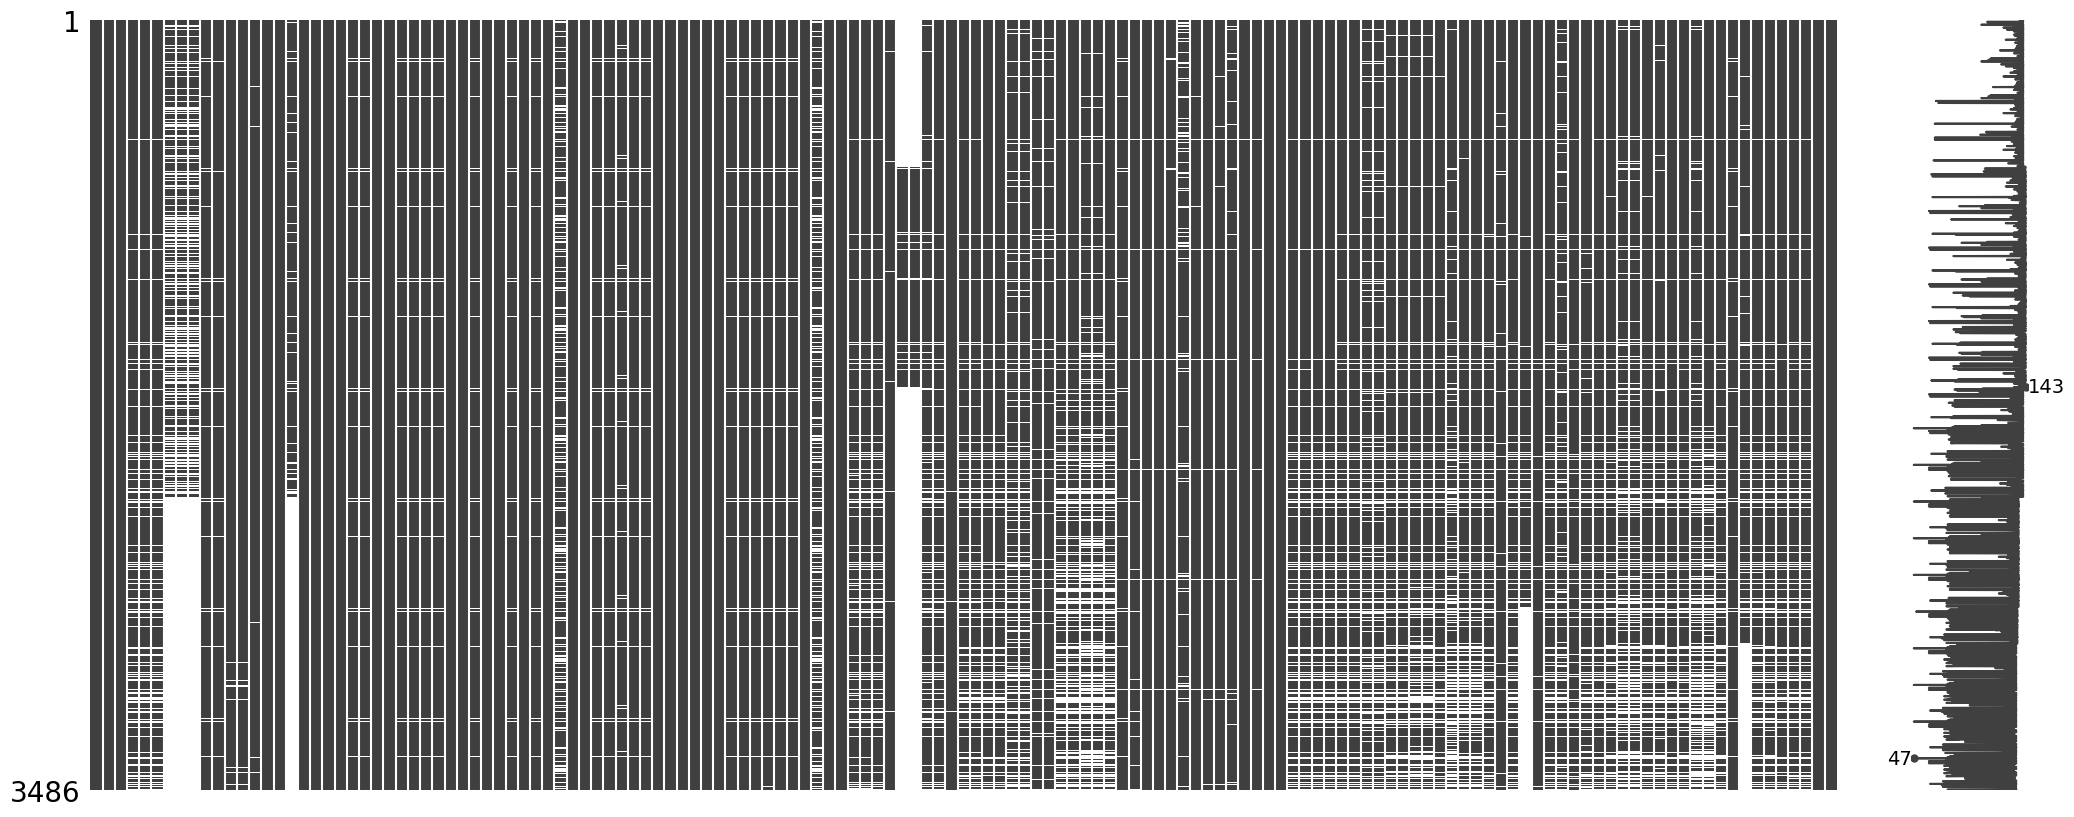

In [11]:
msno.matrix(merged_gdf)

In [12]:
df_copy = df_2022.isna().sum()

df_copy = pd.DataFrame(df_copy, columns=['na_count'])

In [13]:
df_copy.sort_values(by='na_count', ascending=False).head(60)

,na_count
pf_identity_inheritance_widows,2548
pf_identity_inheritance_daughters,2548
pf_rol_procedural,2075
pf_rol_civil,2075
pf_rol_criminal,2075
pf_ss_disappearances_organized,1494
ef_trade_movement_visit,1000
pf_expression_bti,970
pf_assembly_freedom_bti,970
ef_regulation_business_licensing,934


In [14]:
# Create a subset with all attributes except for the outcome-variables
df_attributes = df_2022.drop(columns=['ef_score','hf_score','pf_score'])

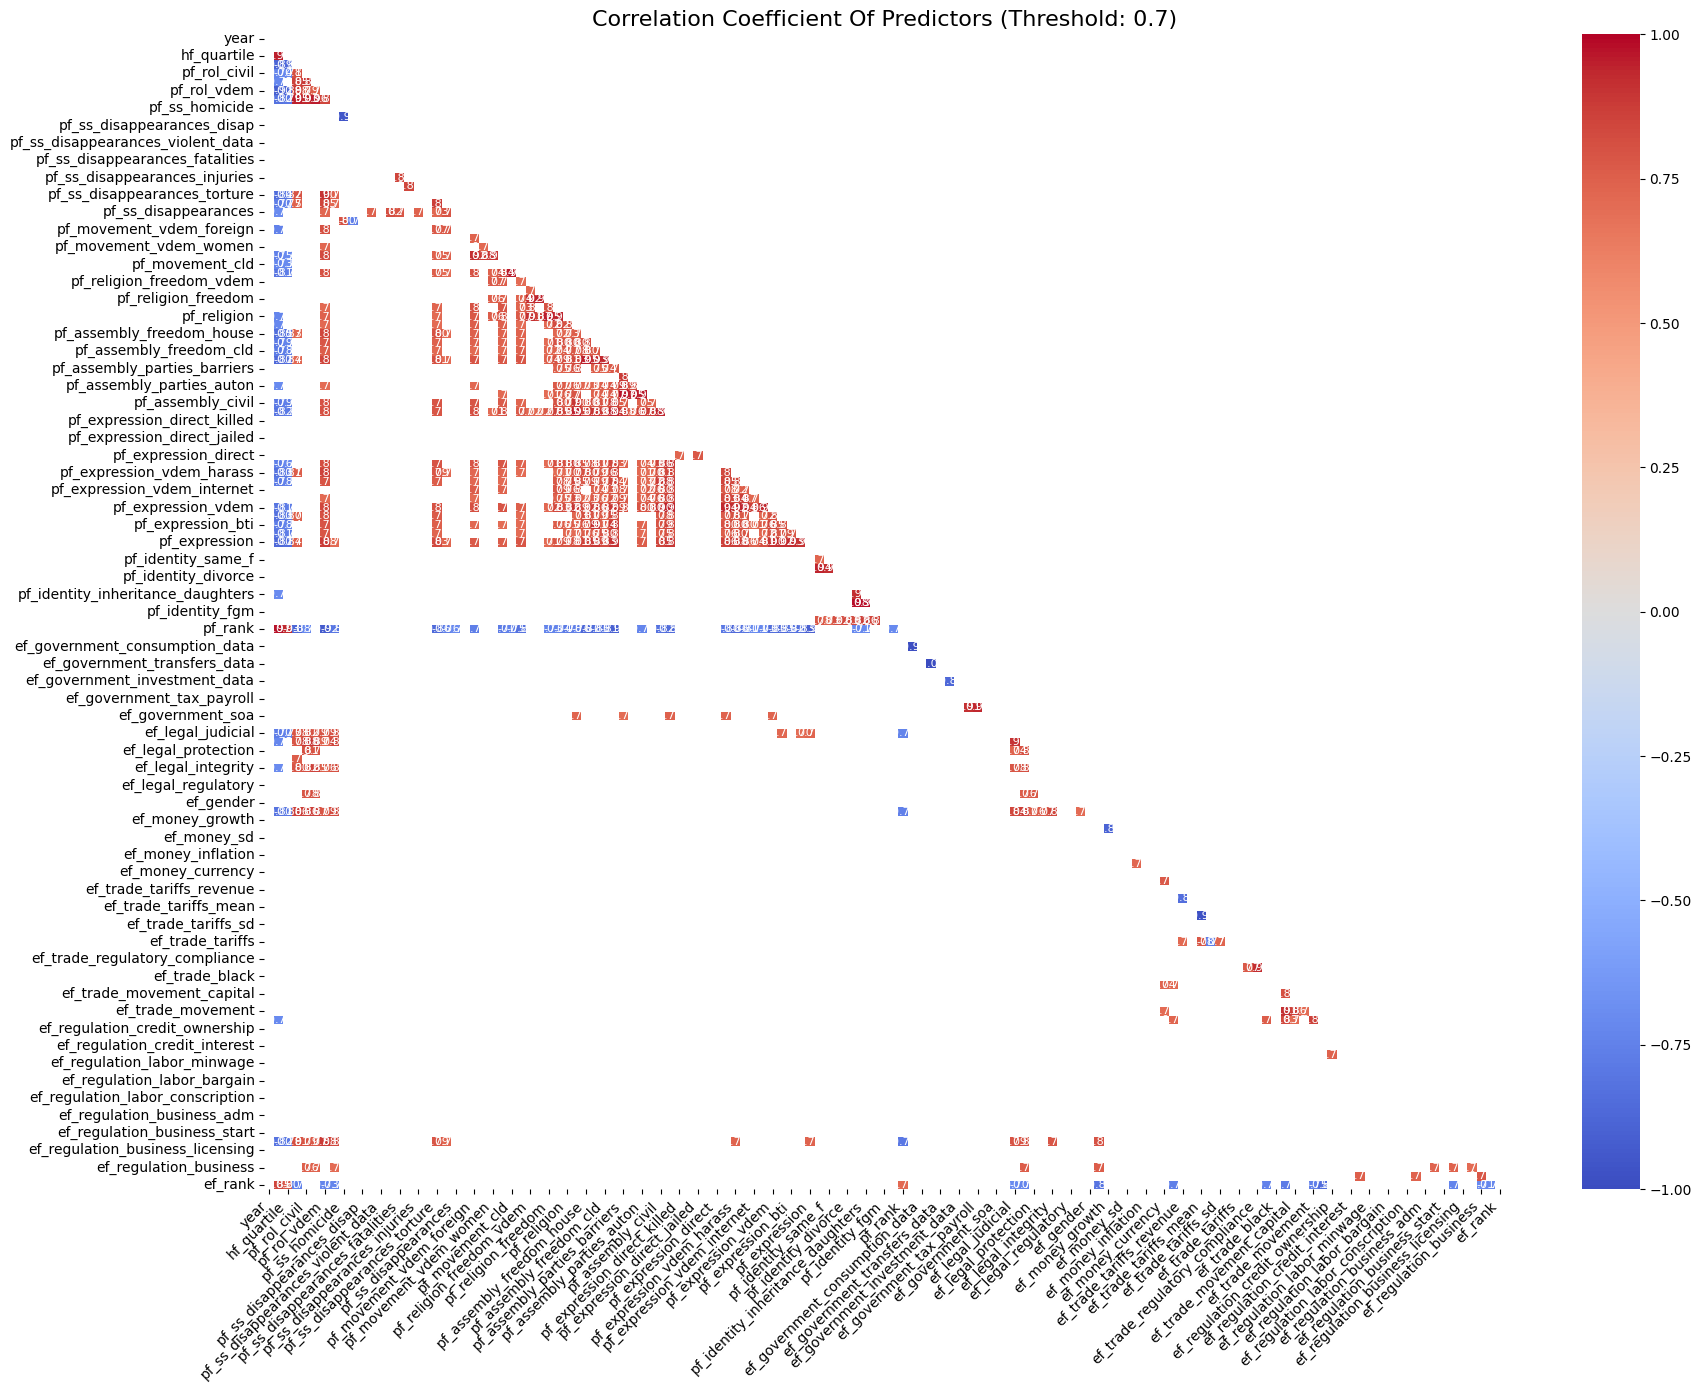

In [15]:
# Heatmap visualizations

# set correlation threshold
corr_threshold = 0.7

# generate correlation matrix
corr_matrix = df_attributes.corr()

# filter to show only highly correlated attributes
high_corr_matrix = corr_matrix[(corr_matrix >= corr_threshold) | (corr_matrix <= -corr_threshold)]

# Generate a mask to only show the bottom triangle
mask = np.triu(np.ones_like(high_corr_matrix, dtype=bool))

# set figure size
plt.figure(figsize=(20, 15))

# generate heatmap
sns.heatmap(high_corr_matrix, annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# rotate x-axis tick labels
plt.xticks(rotation=45, fontsize=10, ha='right')  # Adjust horizontal alignment with `ha` parameter
plt.yticks(fontsize=10)

plt.title(f'Correlation Coefficient Of Predictors (Threshold: {corr_threshold})', fontsize=16)
plt.show()


In [16]:
# Get correlation matrix
corr_matrix = df_attributes.corr()

# Extract features with high correlations
high_correlation_features = set()
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[col, row]) > 0.85:
            high_correlation_features.add(col)
            high_correlation_features.add(row)

# Convert the set to a list
high_correlation_features = list(high_correlation_features)

# Print the list of features
print("Features with high correlations:")
for feature in high_correlation_features:
    print(feature)

Features with high correlations:
pf_identity_inheritance_daughters
pf_rol_procedural
ef_money_growth_data
pf_identity_inheritance
pf_expression_vdem_harass
pf_assembly_parties_bans
pf_identity_inheritance_widows
ef_trade_tariffs_mean
pf_expression_bti
pf_identity_same_f
ef_government_tax_income
pf_expression_house
pf_expression_vdem_selfcens
pf_assembly_parties
ef_government_investment_data
pf_assembly_freedom_house
pf_identity_same_m
pf_ss_homicide_data
pf_ss_killings
ef_legal_courts
ef_government_consumption
ef_government_tax
pf_movement_vdem_women
pf_expression_vdem_cultural
pf_assembly_freedom_bti
ef_government_tax_payroll
pf_assembly
hf_rank
ef_trade
pf_assembly_civil
pf_assembly_freedom
pf_assembly_freedom_cld
pf_movement_vdem_foreign
ef_trade_movement_open
ef_legal_integrity
pf_rol_civil
pf_assembly_entry
pf_ss_homicide
pf_rol_criminal
ef_legal_judicial
pf_identity_same
ef_money_growth
pf_expression_vdem
pf_expression_vdem_internet
pf_rol
pf_movement_vdem
pf_identity
ef_governme

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def find_high_vif_features(df, considered_features, vif_threshold=10):
    X = df[considered_features].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    # Add a constant for the VIF calculation
    X['intercept'] = 1

    # Calculate VIF values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Add features with infinite VIF values to high_vif_features list
    inf_vif_features = vif[vif['VIF'] == float('inf')]['Variable'].tolist()
    high_vif_features = inf_vif_features.copy()

    # Remove features with infinite VIF values from VIF DataFrame
    if inf_vif_features:
        print(f"Removing features with infinite VIF values: {', '.join(inf_vif_features)}")
        vif = vif[vif['VIF'] != float('inf')]
        considered_features = list(set(considered_features) - set(inf_vif_features))

    # Iteratively remove features with VIF values above the threshold
    while (vif['VIF'] > vif_threshold).any():
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]['Variable']
        high_vif_features.append(max_vif_feature)
        print(f"Removing {max_vif_feature} with VIF = {vif.loc[vif['VIF'].idxmax()]['VIF']}")
        vif = vif[vif['Variable'] != max_vif_feature]
        considered_features.remove(max_vif_feature)

    return high_vif_features

# Set a VIF threshold
vif_threshold = 10

# Features to consider removing
considered_features = high_correlation_features

# Find features with high VIF
high_vif_features = find_high_vif_features(df_attributes, considered_features, vif_threshold)

Removing features with infinite VIF values: pf_identity_inheritance_daughters, pf_rol_procedural, pf_identity_inheritance, pf_expression_vdem_harass, pf_assembly_parties_bans, pf_identity_inheritance_widows, ef_trade_tariffs_mean, pf_identity_same_f, ef_government_tax_income, pf_expression_vdem_selfcens, pf_assembly_parties, pf_assembly_freedom_house, pf_identity_same_m, ef_government_tax, pf_movement_vdem_women, pf_expression_vdem_cultural, pf_assembly_freedom_bti, ef_government_tax_payroll, pf_assembly, pf_assembly_civil, pf_assembly_freedom, pf_assembly_freedom_cld, pf_movement_vdem_foreign, pf_rol_civil, pf_assembly_entry, pf_rol_criminal, pf_identity_same, pf_expression_vdem, pf_expression_vdem_internet, pf_rol, pf_movement_vdem, pf_religion_suppression, pf_religion, pf_assembly_parties_barriers, ef_trade_tariffs_mean_data, pf_expression_vdem_gov, pf_religion_freedom_vdem, pf_movement, pf_movement_vdem_men, pf_assembly_parties_auton, pf_movement_cld, pf_religion_freedom, pf_religi

In [18]:
high_vif_features

['pf_identity_inheritance_daughters',
 'pf_rol_procedural',
 'pf_identity_inheritance',
 'pf_expression_vdem_harass',
 'pf_assembly_parties_bans',
 'pf_identity_inheritance_widows',
 'ef_trade_tariffs_mean',
 'pf_identity_same_f',
 'ef_government_tax_income',
 'pf_expression_vdem_selfcens',
 'pf_assembly_parties',
 'pf_assembly_freedom_house',
 'pf_identity_same_m',
 'ef_government_tax',
 'pf_movement_vdem_women',
 'pf_expression_vdem_cultural',
 'pf_assembly_freedom_bti',
 'ef_government_tax_payroll',
 'pf_assembly',
 'pf_assembly_civil',
 'pf_assembly_freedom',
 'pf_assembly_freedom_cld',
 'pf_movement_vdem_foreign',
 'pf_rol_civil',
 'pf_assembly_entry',
 'pf_rol_criminal',
 'pf_identity_same',
 'pf_expression_vdem',
 'pf_expression_vdem_internet',
 'pf_rol',
 'pf_movement_vdem',
 'pf_religion_suppression',
 'pf_religion',
 'pf_assembly_parties_barriers',
 'ef_trade_tariffs_mean_data',
 'pf_expression_vdem_gov',
 'pf_religion_freedom_vdem',
 'pf_movement',
 'pf_movement_vdem_men',
 

In [19]:
# Remove columns with high VIF from df_attributes
df_attributes.drop(high_vif_features, axis=1, inplace=True)

In [20]:
df_attributes

,year,countries,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_rank,country_code
0,2020,Albania,Eastern Europe,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.651538,6.000000,9.742477,5.9975,5.621940,7.175250,6.698118,7.112958,26.0,ALB
1,2020,Algeria,Middle East & North Africa,10.0,9.687083,25.0,5.0,10.000000,0.0,10.000000,...,4.215154,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.778953,157.0,DZA
2,2020,Angola,Sub-Saharan Africa,10.0,9.582498,25.0,7.5,9.736578,5.0,9.971733,...,2.937894,3.111111,8.730805,4.7025,7.916416,6.782923,5.696942,6.227545,138.0,AGO
3,2020,Argentina,Latin America & the Caribbean,5.0,10.000000,0.0,7.5,9.925379,2.0,10.000000,...,2.714233,5.555556,9.579288,7.2675,5.726521,6.508295,6.225232,5.490538,161.0,ARG
4,2020,Armenia,Caucasus & Central Asia,10.0,10.000000,0.0,7.5,10.000000,0.0,10.000000,...,5.170406,5.111111,9.863530,6.2600,9.302574,7.040738,7.124727,7.756333,11.0,ARM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3460,2000,Venezuela,Latin America & the Caribbean,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,6.417950,6.150000,6.268547,4.3100,NaN,0.315142,4.692328,5.531397,87.0,VEN
3461,2000,Vietnam,South Asia,10.0,10.000000,0.0,NaN,10.000000,0.0,10.000000,...,NaN,NaN,7.885638,3.7000,NaN,0.000000,3.861879,4.416768,105.0,VNM
3462,2000,Yemen,Middle East & North Africa,5.0,10.000000,0.0,NaN,8.170079,19.0,7.932996,...,NaN,NaN,NaN,1.1450,NaN,NaN,NaN,NaN,NaN,YEM
3463,2000,Zambia,Sub-Saharan Africa,10.0,10.000000,0.0,NaN,10.000000,0.0,9.827262,...,NaN,NaN,8.537578,7.0050,NaN,8.520369,8.020982,6.799421,43.0,ZMB


<AxesSubplot:>

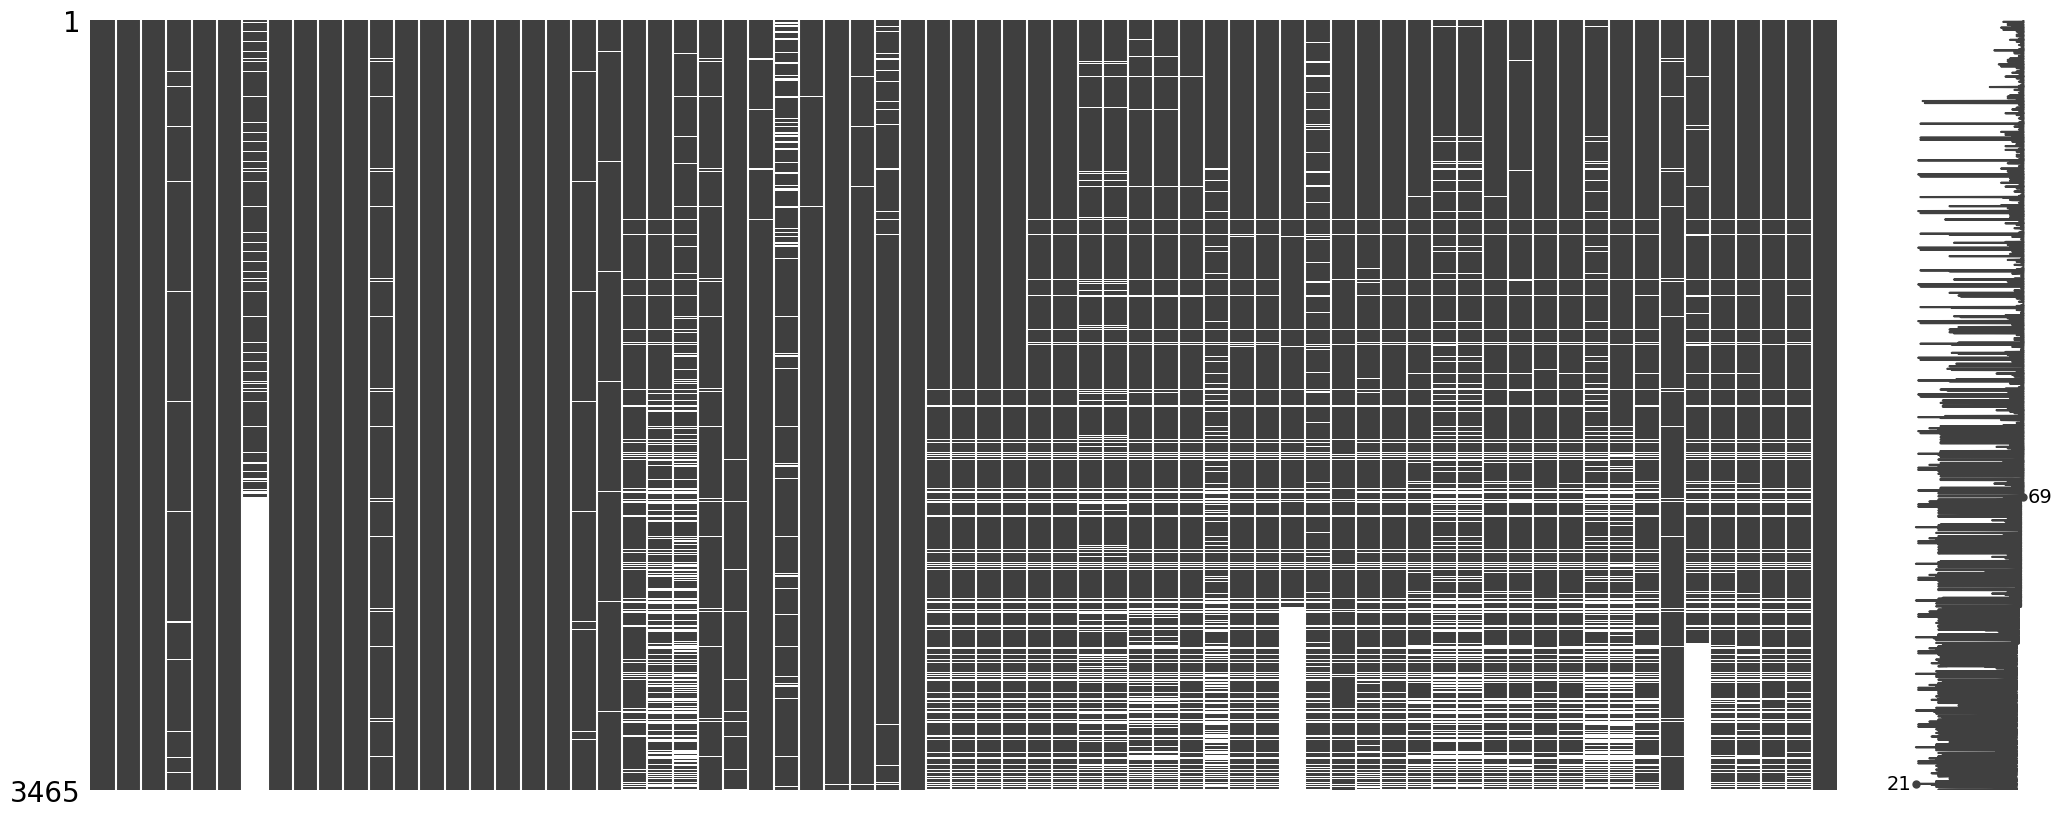

In [21]:
msno.matrix(df_attributes)